<h1> Image Classification using Transfer Learning and Image Augmentation on ResNet50 </h1>
Conventional machine learning techniques tries to learn features from the data. However the problem arises if the dataset is not enough to learn the features required for current Image Classification task. One solution is to use **Transfer Learning** that extracts the knowledge while solving one problem and applying it to a different but related task. Another is to augment the data so as to map the dynamics of real world. <br>The architecture used here is ResNet50. Features from ResNet50 are extracted and applied on our augmented dataset of Natural Scenes.

In [33]:
# necessary imports
import tensorflow as tf
from sklearn.datasets import load_files
import os
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import collections
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
import keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout
from keras.models import Sequential
import sys
import datetime
import glob as glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
import keras as K
from keras.models import load_model
from google.colab import files
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

<h2> Load Dataset </h2>
Here we will download the Dataset of Natural Scene from kaggel intel-image-classification and unzip it in local colab directory <br><br>

In [2]:
#Uploading kaggle.json file

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aamna27","key":"9944f09a800fd209ebde42468fb6f834"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 335M/346M [00:01<00:00, 230MB/s]
100% 346M/346M [00:01<00:00, 238MB/s]


In [ ]:
!unzip intel-image-classification.zip -d Dataset
!rm -rf /content/intel-image-classification.zip

In [ ]:
!rm -rf /content/Dataset/seg_pred
!unzip Test_data.zip -d Dataset

In [11]:
train_dir = 'Dataset/seg_train/seg_train'
validate_dir = 'Dataset/seg_test/seg_test'
test_dir = 'Dataset/seg_pred/seg_pred'

batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))

nb_test_samples = 0
for r, dirs, files in os.walk(test_dir):
    for dr in dirs:
        nb_test_samples += len(glob.glob(os.path.join(r, dr + "/*")))

In [12]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    batch_size = batch_size)

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (32, 32),
    batch_size = batch_size)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32, 32),
    batch_size = batch_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


<h2> Data Augmentation </h2>
Data preparation is almost always required when working with any data analysis, machine learning, neural network or deep learning models. It becomes even more important to augment data in the case of image recognition. Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation

In [10]:

nb_epochs = 20
batch_size = 32
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)
# data pre-processing for validation
test_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [8]:

def res_tl_aug(OPTIMIZER, LEARN_RATE, DECAY, MOMEMTUM, EPOCHS):
    input_t = K.Input(shape=(32,32,3))
    res_model = ResNet50(include_top=False,weights='imagenet', input_tensor= input_t)
    model = K.models.Sequential()
    model.add(res_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.Dense(6, activation='softmax'))
    
    for layer in res_model.layers:
        layer.trainable=(1-True)
    if OPTIMIZER == "RMS":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      rms = K.optimizers.RMSprop(LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=rms)
    if OPTIMIZER == "Adam":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      adam = K.optimizers.Adam(LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    if OPTIMIZER == "SGD":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      sgd = SGD(lr=LEARN_RATE,  momentum=0.9)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)

    return(model)

Adam


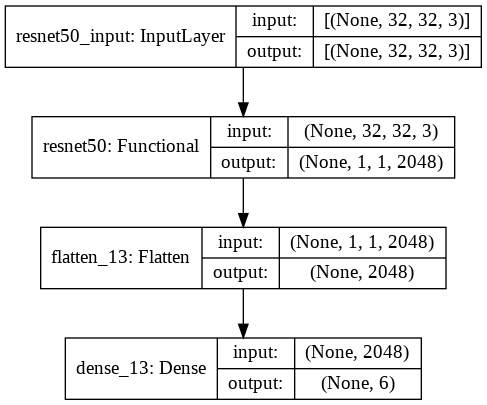

In [35]:
res_model_pic = res_tl_aug("Adam", DECAY= 1e-7, MOMEMTUM = 0.9, LEARN_RATE =0.001, EPOCHS =75)
plot_model(res_model_pic, to_file='Results/RES-AUG-TL-model.png', show_shapes=True)

Making dictionary to store results of experiments

In [7]:

all_acc_dict = collections.OrderedDict()
accdict = {}

<h2> Compile and Train the Model </h2>
Using different choices of optimizers, the model is being trained. **Early Stopping** is being used to tackle number of epochs. Each time a better validation accuracy is achieved the model weights are updated in the directory.


In [13]:

es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('CheckPoints/ResNet-like-Aug-TL-model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

def training(BATCH_SIZE, EPOCHS, OPTIMIZER, LEARN_RATE, DECAY = 0, MOMEMTUM = 0 ):
  accdict = {}
  res = res_tl_aug(OPTIMIZER, DECAY, MOMEMTUM, LEARN_RATE, EPOCHS)
  H = res.fit_generator(
    train_generator,
    epochs = EPOCHS,
    # samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    callbacks=[es,mc])
  trainacc = H.history['accuracy']
  valacc = H.history['val_accuracy']
  trainloss = H.history['loss']
  valloss = H.history['val_loss']
  score = res.evaluate_generator(test_generator)
  accdict["trainacc"] =trainacc[len(trainacc)-1]
  accdict["trainloss"] =trainloss[len(trainloss)-1]
  accdict["valacc"] = valacc[len(valacc)-1]
  accdict["valloss"] = valloss[len(valloss)-1]
  accdict["testacc"] = score[1]
  accdict["testloss"] = score[0]
  
  return H, accdict

In [15]:

History1, all_acc_dict["Adam_Exp1"] = training(32, 25, "Adam", 0.001)

History2, all_acc_dict["Adam_Exp2"] = training(64, 25, "Adam", 0.001)
History3, all_acc_dict["Adam_Exp3"] = training(128, 25,"Adam", 0.001) 
History4, all_acc_dict["SGD_Exp1"] = training(32, 25, "SGD", 0.001)

History5, all_acc_dict["SGD_Exp2"] = training(64, 25, "SGD", 0.001)
History6, all_acc_dict["SGD_Exp3"] = training(128, 25,"SGD", 0.001) 
History7, all_acc_dict["RMS_Exp1"] = training(32, 25, "RMS", 0.001)

History8, all_acc_dict["RMS_Exp2"] = training(64, 25, "RMS", 0.001)
History9, all_acc_dict["RMS_Exp3"] = training(128, 25,"RMS", 0.001) 

Adam
Epoch 1/25


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


439/439 [==============================] - 26s 53ms/step - loss: 1.9336 - accuracy: 0.1754 - val_loss: 1.7598 - val_accuracy: 0.2450

Epoch 00001: val_accuracy did not improve from 0.44733
Epoch 2/25
439/439 [==============================] - 23s 52ms/step - loss: 1.7518 - accuracy: 0.2612 - val_loss: 1.7165 - val_accuracy: 0.2603

Epoch 00002: val_accuracy did not improve from 0.44733
Epoch 3/25
439/439 [==============================] - 23s 52ms/step - loss: 1.7076 - accuracy: 0.2958 - val_loss: 1.6841 - val_accuracy: 0.3067

Epoch 00003: val_accuracy did not improve from 0.44733
Epoch 4/25
439/439 [==============================] - 23s 52ms/step - loss: 1.6743 - accuracy: 0.3209 - val_loss: 1.6519 - val_accuracy: 0.3560

Epoch 00004: val_accuracy did not improve from 0.44733
Epoch 5/25
439/439 [==============================] - 23s 51ms/step - loss: 1.6435 - accuracy: 0.3569 - val_loss: 1.6309 - val_accuracy: 0.3317

Epoch 00005: val_accuracy did not improve from 0.44733
Epoch 6/25


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Adam
Epoch 1/25
439/439 [==============================] - 26s 53ms/step - loss: 2.0999 - accuracy: 0.1676 - val_loss: 1.7802 - val_accuracy: 0.1673

Epoch 00001: val_accuracy did not improve from 0.44733
Epoch 2/25
439/439 [==============================] - 22s 51ms/step - loss: 1.7733 - accuracy: 0.1991 - val_loss: 1.7373 - val_accuracy: 0.2293

Epoch 00002: val_accuracy did not improve from 0.44733
Epoch 3/25
439/439 [==============================] - 23s 51ms/step - loss: 1.7306 - accuracy: 0.2535 - val_loss: 1.7014 - val_accuracy: 0.2963

Epoch 00003: val_accuracy did not improve from 0.44733
Epoch 4/25
439/439 [==============================] - 22s 51ms/step - loss: 1.6923 - accuracy: 0.3050 - val_loss: 1.6776 - val_accuracy: 0.3220

Epoch 00004: val_accuracy did not improve from 0.44733
Epoch 5/25
439/439 [==============================] - 22s 51ms/step - loss: 1.6630 - accuracy: 0.3374 - val_loss: 1.6482 - val_accuracy: 0.3707

Epoch 00005: val_accuracy did not improve from 0.4

<h2> Evaluate the Model </h2>
Model is evaluated on the weights that produced the highest validation accuracy. These weights were stored during training.


In [20]:

saved_model = load_model('CheckPoints/ResNet-like-Aug-TL-model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate_generator(train_generator, verbose=0)
_, val_acc = saved_model.evaluate_generator(validate_generator, verbose=0)
_, test_acc = saved_model.evaluate_generator(test_generator, verbose=0)
print('Train: %.3f,Val: %.3f, Test: %.3f' % (train_acc, val_acc,  test_acc))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train: 0.453,Val: 0.457, Test: 0.466


<h2> Plotting Training and Validation accuracy of different optimizers </h2>

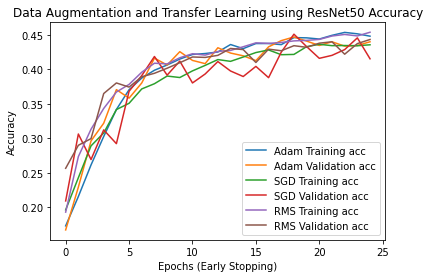

In [25]:

History =0
History = History2
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Accuracy')
plt.title('Data Augmentation and Transfer Learning using ResNet50 Accuracy')

plt.plot(epochs, acc, label='Adam Training acc')
plt.plot(epochs, val_acc, label='Adam Validation acc')

History =0
History = History4
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='SGD Training acc')
plt.plot(epochs, val_acc, label='SGD Validation acc')



History =0
History = History7
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='RMS Training acc')
plt.plot(epochs, val_acc, label='RMS Validation acc')
plt.legend()
plt.savefig("Results/DataAugResNet50Historyacc.png")



<h2> Plotting Training and Validation accuracy of different optimizers </h2>

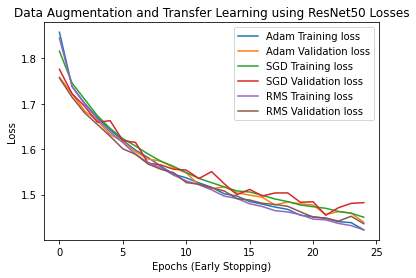

In [24]:

History =0
History = History3
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(loss))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Loss')
plt.title('Data Augmentation and Transfer Learning using ResNet50 Losses')

plt.plot(epochs, loss, label='Adam Training loss')
plt.plot(epochs, val_loss, label='Adam Validation loss')

History =0
History = History5
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='SGD Training loss')
plt.plot(epochs, val_loss, label='SGD Validation loss')



History =0
History = History7
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='RMS Training loss')
plt.plot(epochs, val_loss, label='RMS Validation loss')
plt.savefig("Results/DataAugResNet50Historyloss.png")
plt.legend()


<h2> Predict on Unseen Images </h2>


In [27]:

saved_model = load_model('CheckPoints/ResNet-like-Aug-TL-model.h5')
predY = saved_model.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<h2> Confusion Matrix </h2>

In [28]:

predY_classes = predY.argmax(1)
confusion_matrix = pd.crosstab(test_generator.classes, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
col_0    0     1     2     3    4     5   All
row_0                                        
0       90   252   255   267   72   208  1144
1       96   261   241   282   96   190  1166
2      111   316   310   305   94   194  1330
3      108   278   290   295  100   226  1297
4       84   270   220   272   83   199  1128
5       99   278   250   316   91   202  1236
All    588  1655  1566  1737  536  1219  7301


In [29]:

predY_classes = predY.argmax(1)
confusion_matrix = pd.crosstab(test_generator.classes, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
col_0    0     1     2     3    4     5   All
row_0                                        
0       90   252   255   267   72   208  1144
1       96   261   241   282   96   190  1166
2      111   316   310   305   94   194  1330
3      108   278   290   295  100   226  1297
4       84   270   220   272   83   199  1128
5       99   278   250   316   91   202  1236
All    588  1655  1566  1737  536  1219  7301


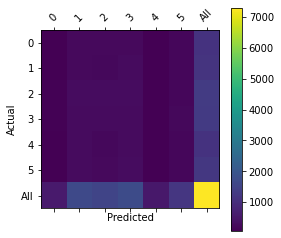

In [30]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  plt.matshow(df_confusion) # imshow
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.savefig("Results/DataAugResnet50Augconfusion.jpg")
#call function
plot_confusion_matrix(confusion_matrix)